# **Importing Libraries**

In [71]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# sklearn imports
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc, RocCurveDisplay)
import joblib
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print("Ready. Libraries imported.")


Ready. Libraries imported.


# **Read Dataset**

In [73]:

path = "/content/heart_disease_uci.csv"
df = pd.read_csv(path)
print("Dataset shape:", df.shape)
display(df.head(10))


Dataset shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
5,6,56,Male,Cleveland,atypical angina,120.0,236.0,False,normal,178.0,False,0.8,upsloping,0.0,normal,0
6,7,62,Female,Cleveland,asymptomatic,140.0,268.0,False,lv hypertrophy,160.0,False,3.6,downsloping,2.0,normal,3
7,8,57,Female,Cleveland,asymptomatic,120.0,354.0,False,normal,163.0,True,0.6,upsloping,0.0,normal,0
8,9,63,Male,Cleveland,asymptomatic,130.0,254.0,False,lv hypertrophy,147.0,False,1.4,flat,1.0,reversable defect,2
9,10,53,Male,Cleveland,asymptomatic,140.0,203.0,True,lv hypertrophy,155.0,True,3.1,downsloping,0.0,reversable defect,1


# **Imputation and Preprocessing**

In [38]:
print("Columns:", df.columns.tolist())

# Check missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Fill missing values
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:  # numerical
        df[col].fillna(df[col].mean(), inplace=True)
    else:  # categorical
        df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing values filled. Recheck:")
print(df.isna().sum())

# Converting to Binary
if 'num' in df.columns:
    df['target'] = (df['num'].astype(float) > 0).astype(int)
    df.drop(columns=['num'], inplace=True)
    print("\nMapped 'num' -> 'target' (binary). Value counts:")
    print(df['target'].value_counts())
else:
    print("\nTarget column assumed to be 'target'.")
    print(df['target'].value_counts())


Columns: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

Missing values per column:
id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

Missing values filled. Recheck:
id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

Mapped 'num' -> 'target' (binary). Value counts:
target
1    509
0    411
Name: count, dtype: int64


In [70]:
display(df.head())

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


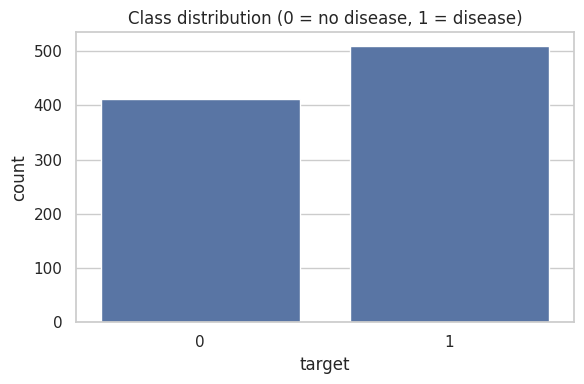

In [61]:
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=df)
plt.title("Class distribution (0 = no disease, 1 = disease)")
plt.xlabel("target")
plt.ylabel("count")
plt.tight_layout()
plt.savefig("class_distribution.png", dpi=150)
plt.show()


# **Encoding and Normalisation**

In [62]:
X = df.drop('target', axis=1)
y = df['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Create a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

print("Data split and preprocessor created.")
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

Data split and preprocessor created.


# **Training LR and SVM**

In [41]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr_model.fit(X_train_pre, y_train)

# SVM
svc_model = SVC(probability=True, random_state=RANDOM_STATE)
svc_model.fit(X_train_pre, y_train)


SVC(probability=True, random_state=42)

In [42]:
# Logistic Regression
train_acc_lr = accuracy_score(y_train, lr_model.predict(X_train_pre))
test_acc_lr = accuracy_score(y_test, lr_model.predict(X_test_pre))

# SVM
train_acc_svc = accuracy_score(y_train, svc_model.predict(X_train_pre))
test_acc_svc = accuracy_score(y_test, svc_model.predict(X_test_pre))



# **Results**

                 Model  Train Accuracy  Test Accuracy
0  Logistic Regression        0.854620       0.891304
1                  SVM        0.894022       0.858696


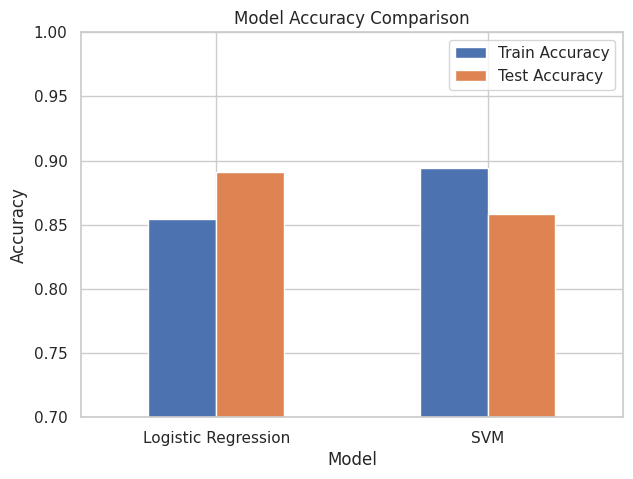

In [43]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM'],
    'Train Accuracy': [train_acc_lr, train_acc_svc],
    'Test Accuracy': [test_acc_lr, test_acc_svc]
})

print(results)

# Bar plot for easy visualization
results.set_index('Model')[['Train Accuracy', 'Test Accuracy']].plot(kind='bar', figsize=(7,5))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=0)
plt.show()


# Visualizing Decision Boundary of Logistic Regression using PCA

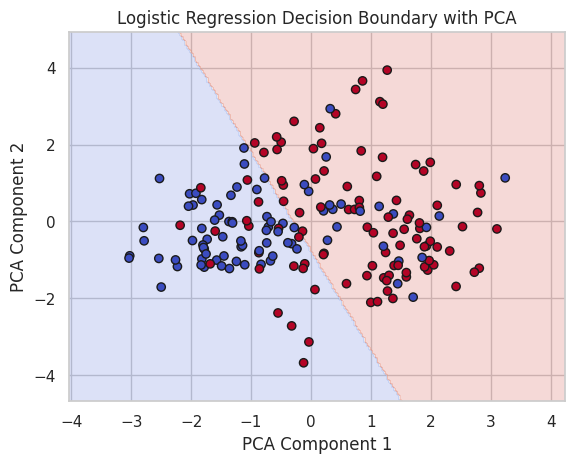

In [68]:
from sklearn.decomposition import PCA

# Apply the existing preprocessor to the data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# PCA to 2 components
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)

# Train logistic regression on PCA components
log_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
log_reg.fit(X_train_pca, y_train)

# Plot decision boundary function
def plot_logistic_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Logistic Regression Decision Boundary with PCA')
    plt.show()

# Plot logistic regression decision boundary with test data
plot_logistic_decision_boundary(X_test_pca, y_test, log_reg)

# Visualizing Decision Boundary of SVM using PCA

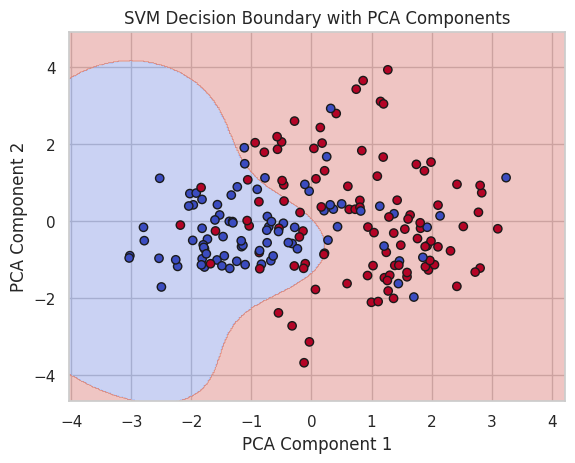

In [69]:
# Apply the existing preprocessor to the data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# PCA to reduce to 2 components
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)

# Train SVM on PCA-transformed data
svm_clf = SVC(kernel='rbf', gamma='scale', C=1)
svm_clf.fit(X_train_pca, y_train)

# Plot decision boundary on PCA components
def plot_decision_boundary(X, y, model):
    h = 0.02  # step size in the mesh

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('SVM Decision Boundary with PCA Components')
    plt.show()

# Plot using test data PCA components and labels
plot_decision_boundary(X_test_pca, y_test, svm_clf)

# Classification Report

In [65]:
from sklearn.metrics import classification_report

print("Logistic Regression Report:\n", classification_report(y_test, lr_model.predict(X_test_pre)))
print("SVM Report:\n", classification_report(y_test, svc_model.predict(X_test_pre)))


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87        82
           1       0.87      0.95      0.91       102

    accuracy                           0.89       184
   macro avg       0.90      0.88      0.89       184
weighted avg       0.89      0.89      0.89       184

SVM Report:
               precision    recall  f1-score   support

           0       0.90      0.77      0.83        82
           1       0.83      0.93      0.88       102

    accuracy                           0.86       184
   macro avg       0.87      0.85      0.85       184
weighted avg       0.86      0.86      0.86       184



# ROC AUC Curve

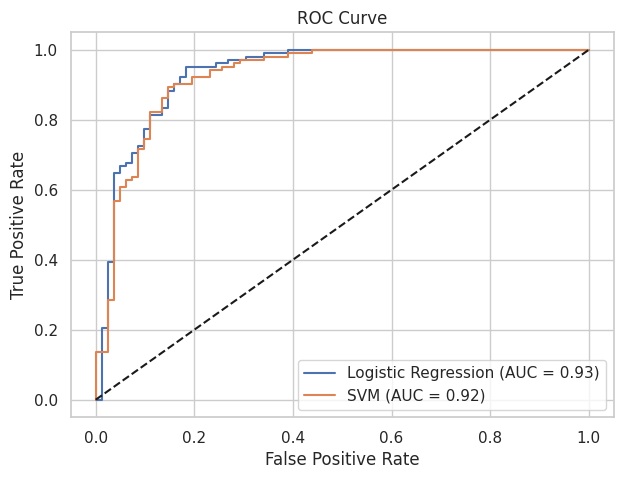

In [67]:
# Logistic Regression
y_prob_lr = lr_model.predict_proba(X_test_pre)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)

# SVM
y_prob_svc = svc_model.predict_proba(X_test_pre)[:,1]
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_prob_svc)
auc_svc = roc_auc_score(y_test, y_prob_svc)

plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_svc, tpr_svc, label=f"SVM (AUC = {auc_svc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
